In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Function to read the data
def read_data(filename):
    data = pd.read_csv(filename, header=None)
    features = data.iloc[:, :-1].values
    labels = data.iloc[:, -1].values - 1  # Shift the class labels to 0-4
    return features, labels

# Read the data
data_url = "https://raw.githubusercontent.com/UMBInal/data/main/data2.csv"
x, y = read_data(data_url)

In [4]:
x.shape

(36670, 10)

In [5]:
y.shape

(36670,)

In [6]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [7]:
x[0]

array([0.01176471, 0.01176471, 0.97647059, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [8]:
y[0]

0

In [9]:
# Split the data into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [10]:
# Reshape the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Determine the input shape and number of classes
input_shape = (x_train.shape[1], 1)
num_classes = len(np.unique(y))

In [12]:
num_classes

5

In [13]:
input_shape

(10, 1)

In [14]:
x_train.shape

(26402, 10, 1)

In [15]:
y_train.shape

(26402,)

In [16]:
x_train[0]

array([[0.03571429],
       [0.02142857],
       [0.91428571],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00714286],
       [0.00714286],
       [0.01428571]])

In [17]:
y_train[0]

0

In [18]:
# Transformer Encoder function with dropout and L2 regularization
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed-forward network with dropout and L2 regularization
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(res)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res

In [19]:
# Transformer Decoder function
def transformer_decoder(inputs, enc_outputs, head_size, num_heads, ff_dim, dropout=0.1, l2_reg=0.01):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(res, enc_outputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = x + res

    # Feed-forward network
    x = layers.Dense(ff_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(inputs.shape[-1], activation = 'softmax')(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    return x + res


In [20]:
# Build the model
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, l2_reg=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    # Encoder
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout, l2_reg)


    # Decoder
    decoder_input = keras.Input(shape=input_shape)
    dec = decoder_input
    for _ in range(num_transformer_blocks):
        dec = transformer_decoder(dec, x, head_size, num_heads, ff_dim, dropout, l2_reg)

    x = layers.Flatten()(x)
    dec = layers.Flatten()(dec)
    x = layers.Concatenate()([x, dec])

    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model([inputs, decoder_input], outputs)
    return model

In [21]:
# Define the hyperparameters

head_size = 69
num_heads = 1
ff_dim = 69
num_transformer_blocks = 1
mlp_units = [69]
dropout = 0.1
mlp_dropout = 0.1
initial_lr = 0.001
l2_reg=0.01

In [22]:
# Build the model
model = build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout, mlp_dropout)

In [23]:
# Create the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_lr)

In [24]:
# Compile the model
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Create the ReduceLROnPlateau callback
lr_callback = ReduceLROnPlateau(factor=0.1, patience=50)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 10, 1)                484       ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 10, 1)                0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 10, 1)                2         ['dropout[0][0]']         

In [27]:
from keras.utils import plot_model

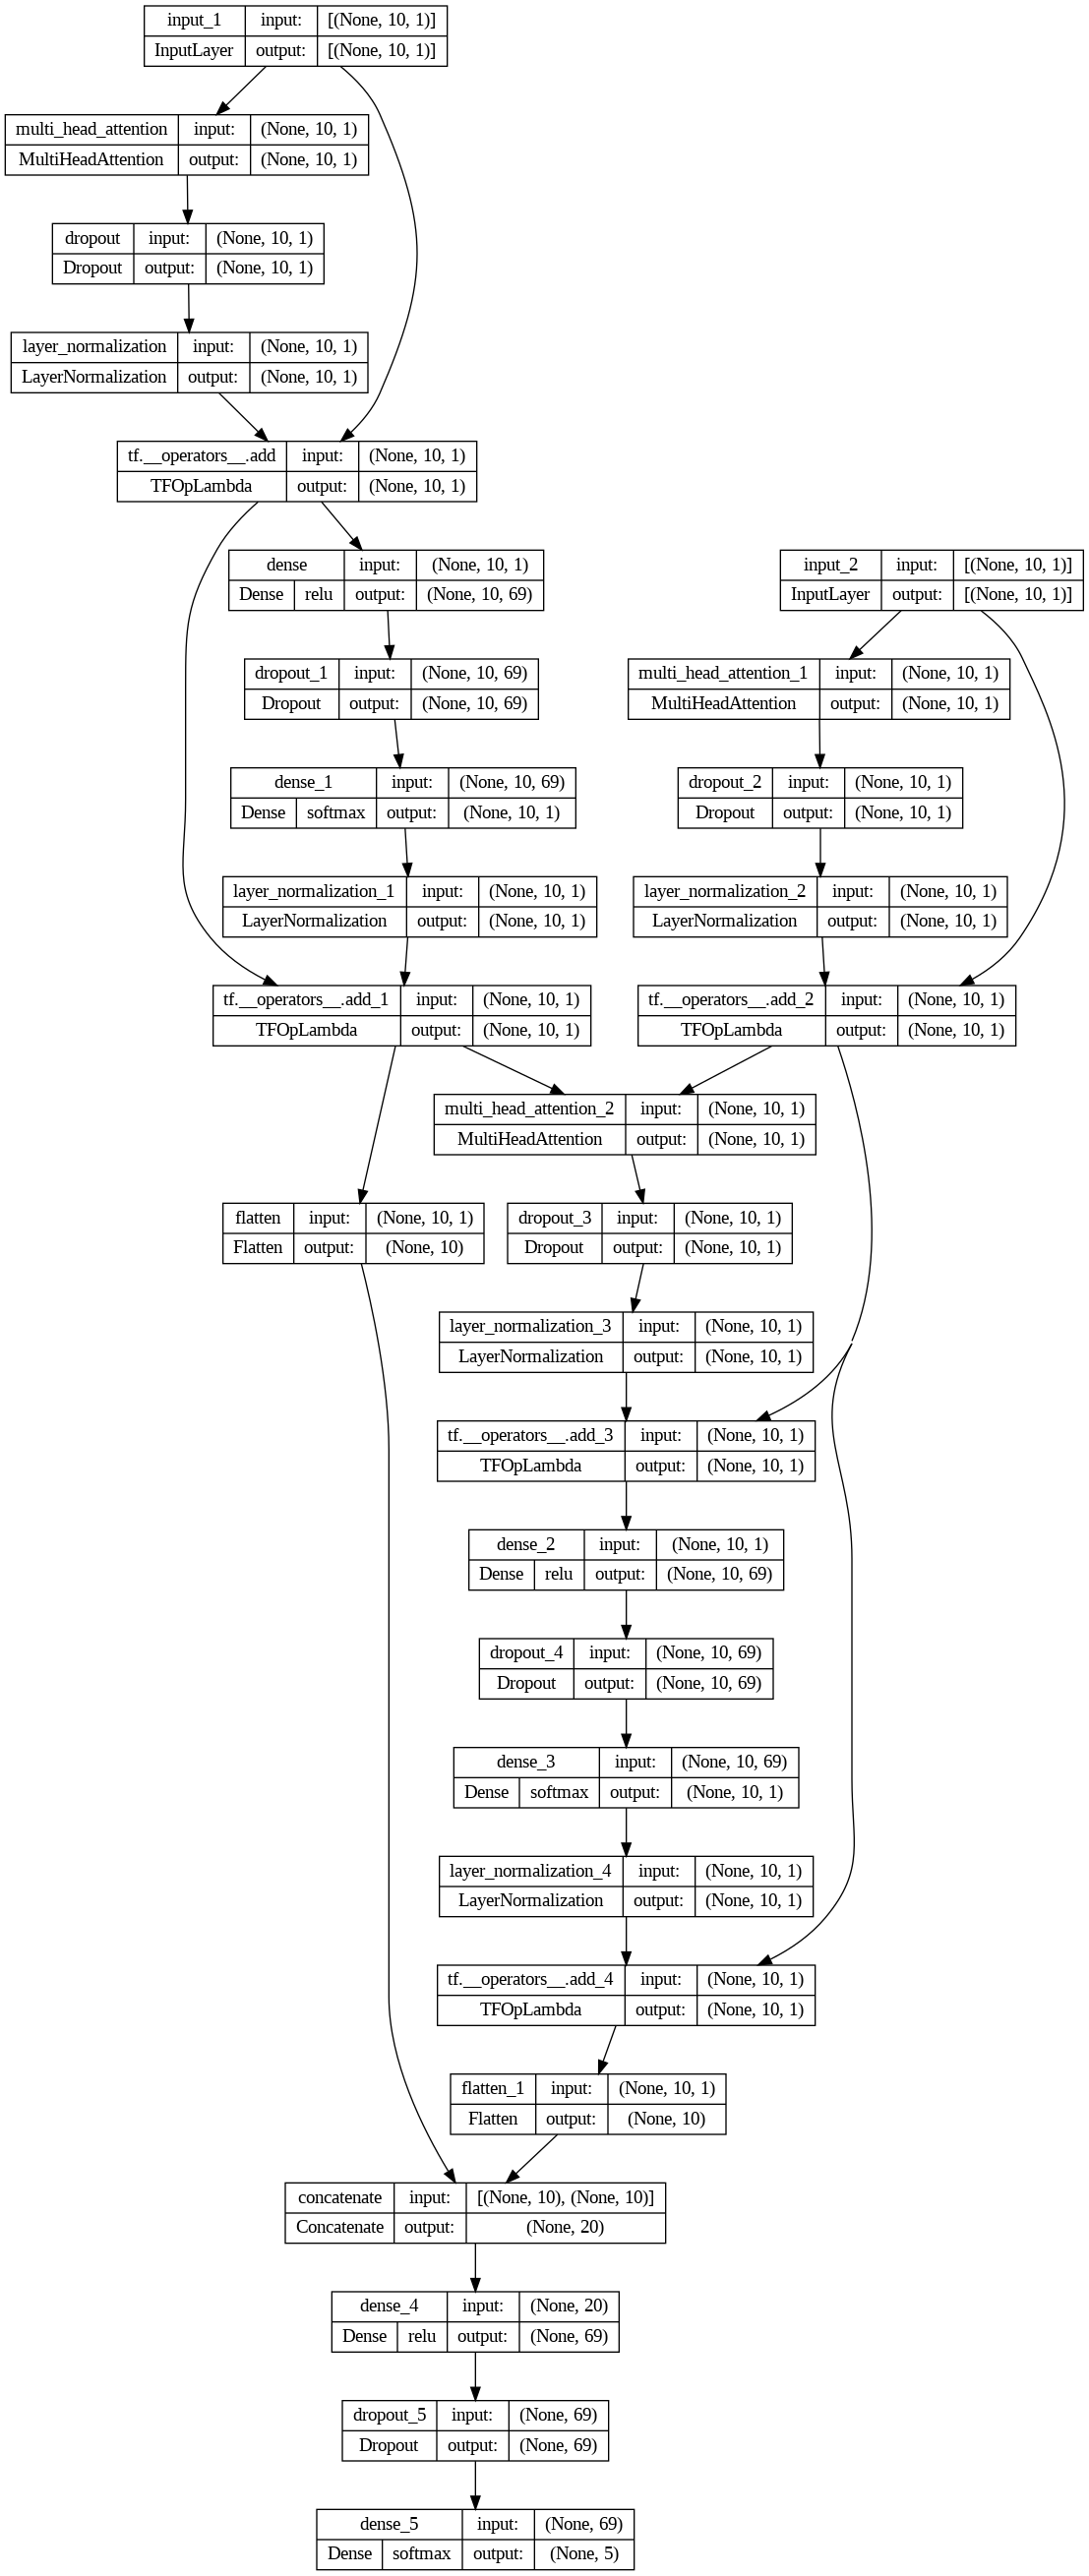

In [28]:
plot_model(model, show_shapes= True, show_layer_activations= True, show_layer_names=True)

In [29]:
'''# Record the start time
start_time = time.time()'''

'# Record the start time\nstart_time = time.time()'

In [30]:
'''model.fit([x_train, x_train], y_train,
          batch_size=64,
          epochs=100,
          validation_data=([x_val, x_val], y_val),
          callbacks=[lr_callback]) '''

'model.fit([x_train, x_train], y_train,\n          batch_size=64,\n          epochs=100,\n          validation_data=([x_val, x_val], y_val),\n          callbacks=[lr_callback]) '

In [31]:
'''# Record the end time
end_time = time.time() '''

'# Record the end time\nend_time = time.time() '

In [32]:
''' # Calculate the total running time
running_time = end_time - start_time
print("Total Running Time: {:.2f} seconds".format(running_time)) '''

' # Calculate the total running time\nrunning_time = end_time - start_time\nprint("Total Running Time: {:.2f} seconds".format(running_time)) '

In [33]:
''' # Evaluate the model
loss, accuracy = model.evaluate([x_test, x_test], y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}") '''

' # Evaluate the model\nloss, accuracy = model.evaluate([x_test, x_test], y_test)\nprint(f"Test loss: {loss}, Test accuracy: {accuracy}") '

In [34]:
'''# Evaluate the model
y_pred = model.predict([x_test, x_test])
y_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels '''

'# Evaluate the model\ny_pred = model.predict([x_test, x_test])\ny_pred = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels '

In [35]:
'''# Define the label mapping
label_mapping = {
    0: 'Sed.',
    1: 'LHH',
    2: 'MtV',
    3: 'Walk',
    4: 'Run'
} '''

"# Define the label mapping\nlabel_mapping = {\n    0: 'Sed.',\n    1: 'LHH',\n    2: 'MtV',\n    3: 'Walk',\n    4: 'Run'\n} "

In [36]:
'''# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred) '''

'# Generate the confusion matrix\ncm = confusion_matrix(y_test, y_pred) '

In [37]:
'''# Plot the confusion matrix with label names
class_names = [label_mapping[label] for label in np.unique(y)]
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()'''

'# Plot the confusion matrix with label names\nclass_names = [label_mapping[label] for label in np.unique(y)]\nfig, ax = plt.subplots(figsize=(8, 6))\nsns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax)\nax.set_xlabel(\'Predicted\')\nax.set_ylabel(\'Actual\')\nplt.show()'

In [38]:
'''# Save the trained model
model.save("my_model_10.h5")'''

'# Save the trained model\nmodel.save("my_model_10.h5")'